In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch

from typing import List
from einops import rearrange, repeat

In [ ]:
from flow_intro.ode import ODE
from flow_intro.ode import SDE
from flow_intro.net import MLP
from flow_intro.train import Trainer
from flow_intro.utils import equal_select
from flow_intro.distrib import Circles, Checkers
from flow_intro.sim import EulerMaruyamaSimulator
from flow_intro.sim import EulerSimulator, Simulator
from flow_intro.path import GaussProbPath, OTProbPath
from flow_intro.field import MLPVectorField, VectorField
from flow_intro.diffusion import DenoisingDiffusionModel
from flow_intro.display import plot_prob_path, plot_trajectory

In [45]:
device = torch.device("cuda:0")

In [46]:
# DATA
p_norm = Circles(n_modes=1)
p_chek = Checkers(n_patches=3, patch_size=4)
p_five = Circles(n_modes=5, scale=torch.tensor([0.3, 0.3]), radius=2*torch.pi)

# NN
model = MLP(in_dim=2, out_dim=2, h_dim=128, num_layers=8).to(device)

# ODE
vtf: VectorField = MLPVectorField(model=model)
ode: ODE = ODE(vector_field=vtf)
sim_euler: Simulator = EulerSimulator(ode=ode)
path = OTProbPath(p_init=p_five, p_data=p_chek)

In [47]:
n_marg = 10
n_steps = 1000
n_samples = 5000
n_choose: int = n_steps // n_marg
step_index: List[int] = [i * n_choose for i in range(n_marg)] + [n_steps - 1]

In [48]:
trainer = Trainer(
    loss_every=1024,
    batch_size=2048,
    device=device,
    steps=10_000,
    model=model,
    path=path,
    lr=1e-3,
)

In [49]:
trainer.train()

Loss: 27.97, Step: 9216: 100%|██████████| 10000/10000 [00:14<00:00, 703.06it/s]


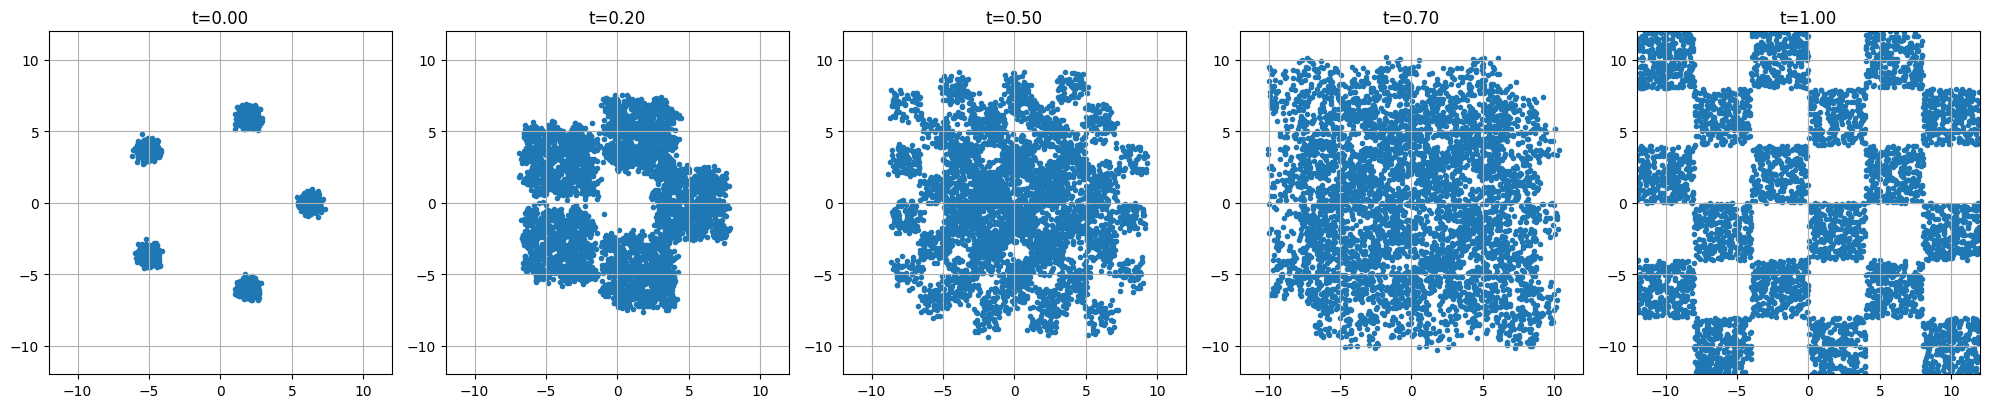

In [50]:
t_steps = torch.linspace(0, 1, steps=n_steps)
t = repeat(t_steps, 't -> (t n) 1', n=n_samples)
x_t = path.sample_marginal(t)
x_t = rearrange(x_t, '(t n) d -> t n d', n=n_samples)

t = t.reshape(-1, n_samples)[step_index, 0]
x_t = x_t[step_index]

plot_prob_path(equal_select(x_t, 5), equal_select(t, 5))

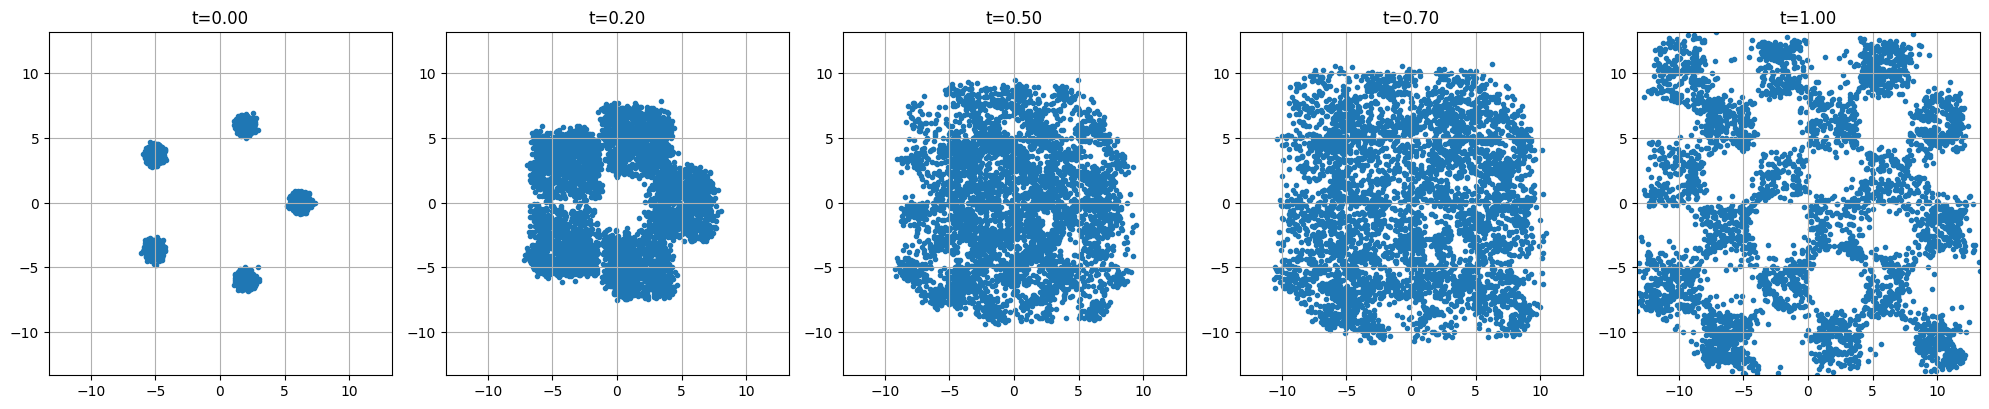

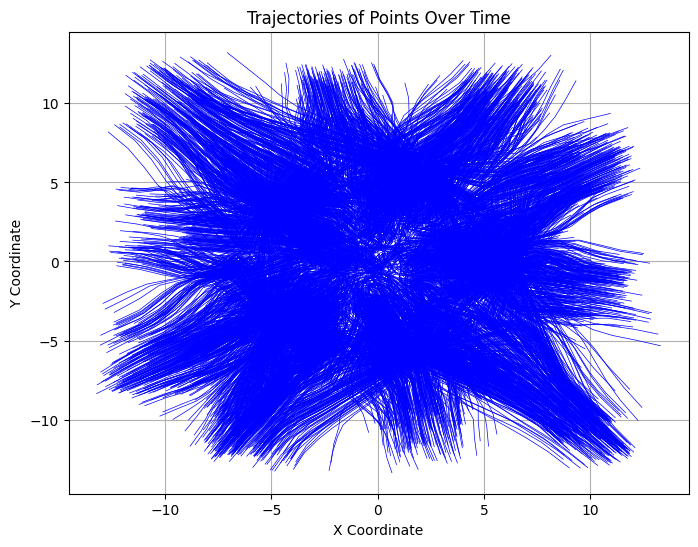

In [51]:
with torch.no_grad():
    t = torch.linspace(0, 1, n_steps)
    x_0 = path.sample_init(n_samples)
    x_t = sim_euler.trajectory(x_0.to(device), t.to(device)).cpu()
    x_t = x_t[step_index]
    t = t[step_index]
    plot_prob_path(equal_select(x_t, 5), equal_select(t, 5))
    plot_trajectory(x_t)

In [52]:
if isinstance(path, GaussProbPath):
    with torch.no_grad():
        # ODE -> SDE
        ddm = DenoisingDiffusionModel(prob_path=path, vector_field=vtf)
        sde = SDE(sigma=torch.tensor(1.5), diffusion_model=ddm)
        sim_euler_maryuama = EulerMaruyamaSimulator(sde=sde)

        # Perform DDPM Sampling
        t = torch.linspace(0.01, 1, n_steps)
        x_0 = path.sample_init(n_samples)
        x_t = sim_euler_maryuama.trajectory(x_0.to(device), t.to(device)).cpu()
        x_t = x_t[step_index]
        t = t[step_index]
        plot_prob_path(equal_select(x_t, 5), equal_select(t, 5))
        plot_trajectory(x_t)